# Utility function for evaluation

In [9]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import laplacian_kernel, rbf_kernel
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix

# Calculate sensitivity and specificity based on the confusion matrix.
def calculate_se_sp(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  specificity = tn / (tn+fp)
  sensitivity = tp / (tp+fn)

  return sensitivity, specificity

# Calculate sensitivity, specificity, and geometric mean for a given threshold T.
# The function also classifies predictions based on threshold T.
def calculate_se_sp_gmeans_with_threshold_(y_true, y_pred, T=0):
  y_pred_class = np.zeros(len(y_pred))
  y_pred_class[y_pred > T] = 1
  se, sp = calculate_se_sp(y_true, y_pred_class)

  return {"se": se,
          "sp": sp,
          "g_mean": np.sqrt(se * sp),
          'T':T
          }

# Calculates Partial AUC
def calculate_partial_auc(y_true, y_scores, sensitivity_threshold=0.8):

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    idx = np.where(tpr > sensitivity_threshold)

    fpr_partial = fpr[idx]
    tpr_partial = tpr[idx]

    try:

      partial_auc = auc(fpr_partial, tpr_partial)

    except:
      print('auc error')
      partial_auc = 0

    return partial_auc

def evaluate(y_true, y_pred, T=0, se=0.8):
  result = calculate_se_sp_gmeans_with_threshold_(y_true, y_pred, T)
  partial_auc = calculate_partial_auc(y_true, y_pred, se)
  result['partial_auc'] = partial_auc
  return result

# L2 Normalization
def normalize(df, feature_cols, selected_cols):
  features = df[feature_cols].values
  features_norm = np.sqrt(np.sum(features**2, axis=1))
  features_test = features / features_norm[:, np.newaxis]
  return features_test[:, selected_cols]

# Calculate initial weight as the ratio : N^-/ (N^+ * 2). (to apply custom weight)
def get_initial_neg_weight(y):
  return y.shape[0]/ ((y.shape[0]-y.sum()) * 2)

# Below is the code for preprocessing the data. We didn't put the detailed comment as the output should be the same as matlab version

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd
import numpy as np

feature_cols = [f'x{i}' for i in range(30)]

# Indices of the selected feature (adjusted for zero-based indexing)
peaks_to_retain = [5, 7, 9, 17, 18, 25, 29, 3, 4, 6, 11, 13, 15, 19, 21, 23, 26, 27, 28]
peaks_to_retain = [index - 1 for index in peaks_to_retain]

import scipy.io
mat = scipy.io.loadmat('/content/drive/MyDrive/Tissue Identification/full_spectra_feature_set_b12g.mat') #path to data

import pandas as pd

df = pd.DataFrame({
    "patient_id": mat['batch2_pat_id'].flatten(),
    "target": mat['batch2_class_id'].flatten(), #<-will be processed later
    "class_id": mat['batch2_class_id'].flatten()
})
df_features = pd.DataFrame(mat['batch2_feat'], columns=feature_cols)
df = pd.concat((df, df_features), axis=1)
df['id'] = df.index
df.loc[df['target'] != 1, 'target'] = 0
df_patient = df.groupby(['patient_id']).mean().reset_index()[['patient_id', "target"]]
df_patient.loc[df_patient['target'] > 0, 'target'] = 1
df = pd.DataFrame(df[df['class_id'] != 3]).reset_index(drop=True)
df_all_train = df.fillna(0).copy()

################################################################################

df_test = pd.DataFrame({
    "patient_id": mat['batchg_pat_id'].flatten(),
    "target": mat['batchg_class_id'].flatten(), #<-will be processed later
    "class_id": mat['batchg_class_id'].flatten()
})
df_test_features = pd.DataFrame(mat['batchg_feat'], columns=feature_cols)
df_test = pd.concat((df_test, df_test_features), axis=1)
df_test['id'] = df_test.index
df_test.loc[df_test['target'] != 1, 'target'] = 0
df_test = pd.DataFrame(df_test[df_test['class_id'] != 3]).reset_index(drop=True)
df_test = df_test.fillna(0)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
X_train = normalize(df_all_train, feature_cols, peaks_to_retain)
y_train = df_all_train['target'].values

X_test = normalize(df_test, feature_cols, peaks_to_retain)
y_test = df_test['target'].values

In [7]:
X_train

array([[1.54583271e-02, 2.91736912e-02, 8.84289256e-02, ...,
        7.07980251e-01, 5.19300100e-02, 7.84081779e-02],
       [1.95770553e-02, 2.91327504e-02, 6.44896192e-02, ...,
        6.97096718e-01, 5.49123324e-02, 7.62699631e-02],
       [1.44953164e-02, 4.87302605e-02, 3.37123394e-02, ...,
        7.01940004e-01, 6.13487237e-02, 7.70064369e-02],
       ...,
       [7.82731501e-03, 6.77351987e-04, 1.59877729e-01, ...,
        7.15674499e-01, 2.85757621e-02, 5.99570575e-02],
       [8.05998688e-03, 2.26376013e-03, 1.48850255e-01, ...,
        7.31331224e-01, 3.46706430e-02, 6.43027707e-02],
       [1.48836374e-02, 1.66577592e-02, 1.04835356e-01, ...,
        6.73543535e-01, 3.89907023e-02, 6.18259816e-02]])

In [8]:
y_train

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

# Cost Sensitive SVM (Tuned C+:C-) - Train and test on full data with optimal params

In [10]:
from sklearn.svm import SVC

# Calculates the initial weight
neg_weight = get_initial_neg_weight(y_train)

svm = SVC(kernel="rbf", class_weight={0: neg_weight, 1: neg_weight*2}, C=1, gamma=0.05)
svm.fit(X_train, y_train)

SVC(C=1, class_weight={0: 0.5118122354751827, 1: 1.0236244709503655},
    gamma=0.05)

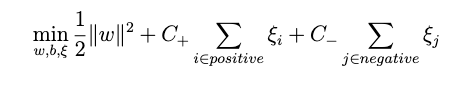

# Evaluate

In [11]:
y_train_pred = svm.decision_function(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
best_T = thresholds[np.argmax(tpr >= 0.8)]
train_results = evaluate(y_train, y_train_pred, best_T)

y_pred = svm.decision_function(X_test)

final_result = evaluate(y_test, y_pred, best_T)
final_result

{'se': 0.8372093023255814,
 'sp': 0.9214139344262295,
 'g_mean': 0.8783030895960987,
 'T': -0.9957255003661061,
 'partial_auc': 0.9204060236370568}